## Want to look at whether the quality of the sequences is dependent on the run or species

Since the majority of the tools (at least the new ones) use quality, what impact does experiment have on the quality of the sequence

In [1]:
import os
import pandas as pd
data_dir = '../quality_h5py/'
fig_dir = '../figs/'
files = os.listdir(data_dir)
runs = [f.split('_')[0] for f in files]

## Get the genes that were shared 

For a specific gene, let's have a look if the quality for that gene is dataset specific

In [2]:
common_df = pd.read_csv(f'../output/shared_genes_in_assemblies.csv')
chrs = common_df['chr']
starts = common_df['start']
common_df['gene_ID'] = [f'{chrs[i]}:{starts[i] - 1}-{end}' for i, end in enumerate(common_df['end'].values)]
common_df['gene_biotype'].value_counts()
common_df

,Source,chr,start,end,strand,ID,Name,GeneID,Dbxref,locus_tag,gene,gene_biotype,gene_ID
0,GCF_001701835.2_ASM170183v2_genes-RNA.gff,NZ_CP027036.1,5066071,5066991,-,gene-A6D82_RS25385,accD,NaN,NaN,A6D82_RS25385,accD,protein_coding,NZ_CP027036.1:5066070-5066991
1,GCF_021459925.1_ASM2145992v1_genes-RNA.gff,NZ_CP090518.1,849816,850712,+,gene-LZ752_RS03645,accD,NaN,NaN,LZ752_RS03645,accD,protein_coding,NZ_CP090518.1:849815-850712
2,GCF_022226995.1_ASM2222699v1_genes-RNA.gff,NZ_CP092052.1,1740276,1741133,-,gene-AH5667_RS08480,accD,NaN,NaN,AH5667_RS08480,accD,protein_coding,NZ_CP092052.1:1740275-1741133
3,GCF_000005845.2_ASM584v2_genes-RNA.gff,NC_000913.3,2433012,2433926,-,gene-b2316,accD,NaN,"ASAP:ABE-0007648,ECOCYC:EG10217,GeneID:946796",b2316,accD,protein_coding,NC_000913.3:2433011-2433926
4,GCF_000196035.1_ASM19603v1_genes-RNA.gff,NC_003210.1,1612395,1613279,-,gene-lmo1573,accD,NaN,GeneID:986998,lmo1573,accD,protein_coding,NC_003210.1:1612394-1613279
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2841,GCF_000014625.1_ASM1462v1_genes-RNA.gff,NC_008463.1,1289880,1291259,-,gene-PA14_RS06065,xseA,NaN,NaN,PA14_RS06065,xseA,protein_coding,NC_008463.1:1289879-1291259
2842,GCF_000026545.1_ASM2654v1_genes-RNA.gff,NC_011601.1,2855806,2857179,+,gene-E2348C_RS14910,xseA,NaN,NaN,E2348C_RS14910,xseA,protein_coding,NC_011601.1:2855805-2857179
2843,GCF_022226995.1_ASM2222699v1_genes-RNA.gff,NZ_CP092052.1,1571498,1572835,-,gene-AH5667_RS07620,xseA,NaN,NaN,AH5667_RS07620,xseA,protein_coding,NZ_CP092052.1:1571497-1572835
2844,GCF_001701425.2_ASM170142v2_genes-RNA.gff,NZ_CP027042.1,1310265,1311656,-,gene-A6D67_RS06605,xseA,NaN,NaN,A6D67_RS06605,xseA,protein_coding,NZ_CP027042.1:1310264-1311656


In [3]:
# We need to look at what the runs map to
mapping_df = pd.read_csv(f'../output/mapping.csv')
data = '../data_refs/'
meta = pd.read_csv(f'{data}SraRunTable_RNAseq_bacteria_oxfordnanopore.csv')
run_to_ass = pd.read_csv(f'../output/run_to_assembly.csv')
ass_dict = dict(zip(run_to_ass['Run'], run_to_ass['AssemblyID']))
name_dict = dict(zip(run_to_ass['Run'], run_to_ass['Name']))

## Essentially from the run we can get the name of the organism

Let's limit this to start off with to just ecoli which has the benchmarking data.

For some genes that are known to be modified, let's have a look at how it performs.

In [4]:
ecoli = run_to_ass[run_to_ass['Name'] == 'Escherichiacoli-K_12']
runs = [run.split('.')[0] for run in runs]
ecoli_runs = [run for run in ecoli['Run'].values if run in runs]
ecoli_runs

['SRR12090426',
 'SRR12090427',
 'SRR12090428',
 'SRR12090429',
 'SRR12090430',
 'SRR12090431',
 'SRR12090432',
 'SRR12090433',
 'SRR12090434',
 'SRR12090435',
 'SRR18061002',
 'SRR18061005']

In [6]:
# pick a specific gene from the common df
# Look at accD to start off with
import pandas as pd
import numpy as np
import h5py
from tqdm import tqdm

references = ['_'.join(x.split('_')[:2]) for x in common_df['Source'].values]
common_df['AssemblyID'] = references
# Get the runs that are
values = []
genes = ['pheT',
 'truB',
 'rpsI',
 'tgt',
 'lysS',
 'trmD',
 'rplE',
 'rpmA',
 'mnmA',
 'miaA',
 'leuS',
 'rpmG',
 'pheS',
 'trmB',
 'cysS',
 'ileS',
 'rplA',
 'rpsM',
 'tyrS',
 'gltX',
 'rpsS',
 'aspS',
 'prmA',
 'thrS',
 'rplP',
 'rpsJ',
 'rpsG',
 'rnpA',
 'rpsL',
 'argS',
 'truA',
 'hisS',
 'serS',
 'alaS']
for run in runs:
    print(run)
    run_run = h5py.File(f'{data_dir}{run}.h5', 'r')
    for gene in genes: #list(set(common_df['Name'].values))): #, 'dapA', 'rpmG', 'trmD', 'purE']:
        try:
            # Want to get the qualities for that gene in the quality df 
            gene_df = common_df[common_df['Name'] == gene]
            
            gene_id = gene_df[gene_df['AssemblyID'] == ass_dict.get(run)]['gene_ID'].values[0]
            gene_reads = run_run[gene_id]

            for read in gene_reads:
                quality = run_run[gene_id][read]
                quals = [int(x) for x in quality]
                values.append([run, gene, gene_id, read, np.mean(quals), np.median(quals), np.std(quals)])

        except:
            y = 1
    try:
        run_run.close()
    except:
        x = 1

BlockingIOError: [Errno 11] Unable to open file (unable to lock file, errno = 11, error message = 'Resource temporarily unavailable')

In [7]:
vis_df = pd.DataFrame(values, columns=['Run', 'Gene', 'gene_id', 'read', 'Mean', 'Median', 'Stdev'])
vis_df['Annotation'] = [name_dict.get(run) for run in list(vis_df['Run'].values)]
vis_df

,Run,Gene,gene_id,read,Mean,Median,Stdev,Annotation
0,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.102929:0-667,19.994042,21.0,8.641484,Escherichiacoli-K_12
1,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.113671:0-1948,21.840979,23.0,9.898218,Escherichiacoli-K_12
2,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.115583:0-146,14.984375,15.0,7.882917,Escherichiacoli-K_12
3,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.117345:0-1518,22.084363,23.0,10.020392,Escherichiacoli-K_12
4,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.122477:0-539,19.242842,20.0,11.147587,Escherichiacoli-K_12
...,...,...,...,...,...,...,...,...
427192,SRR13212619,cysS,NC_003210.1:259476-260892,SRR13212619.169190:504-683,20.299595,20.0,11.367229,Listeriamonocytogenes-ref
427193,SRR13212619,ileS,NC_003210.1:2097175-2099941,SRR13212619.9803:7-748,18.706444,19.0,9.876311,Listeriamonocytogenes-ref
427194,SRR13212619,gltX,NC_003210.1:256982-258458,SRR13212619.318778:0-1476,19.666866,20.0,9.631832,Listeriamonocytogenes-ref
427195,SRR13212619,rpsG,NC_003210.1:2729456-2729927,SRR13212619.109392:14-471,18.335498,19.0,9.004208,Listeriamonocytogenes-ref


In [8]:
# import numpy as np
# from tqdm import tqdm
# gene_dfs = {}
# # pick a specific gene from the common df
# # Look at accD to start off with
# quality_data = []
# for gene in tqdm(list(set(common_df['Name'].values))): #, 'dapA', 'rpmG', 'trmD', 'purE']:
#     # Get the runs that are
#     gene_df = common_df[common_df['Name'] == gene]
#     references = ['_'.join(x.split('_')[:2]) for x in gene_df['Source'].values]
#     gene_df['AssemblyID'] = references
#     for run in runs:
#         # Want to get the qualities for that gene in the quality df 
#         df = loaded_dfs[run]
#         gene_id = gene_df[gene_df['AssemblyID'] == ass_dict.get(run)]['gene_ID'].values[0]
#         gene_values = df[df['1'] == gene_id]
#         if len(gene) > 0:
#             for g in gene_values.values:
#                 row = [gene, name_dict[run], run, np.nanmean(g[3:].astype(float)), np.nanmedian(g[3:].astype(float))]
#             quality_data.append(row)
#vis_df = pd.DataFrame(quality_data, columns=['Gene', 'Annotation', 'Run', 'Mean', 'Median'])
#vis_df

In [22]:
vis_df

,Run,Gene,gene_id,read,Mean,Median,Stdev,Annotation
0,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.102929:0-667,19.994042,21.0,8.641484,Escherichiacoli-K_12
1,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.113671:0-1948,21.840979,23.0,9.898218,Escherichiacoli-K_12
2,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.115583:0-146,14.984375,15.0,7.882917,Escherichiacoli-K_12
3,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.117345:0-1518,22.084363,23.0,10.020392,Escherichiacoli-K_12
4,SRR12090428,pheT,NC_000913.3:1795556-1797944,SRR12090428.122477:0-539,19.242842,20.0,11.147587,Escherichiacoli-K_12
...,...,...,...,...,...,...,...,...
427192,SRR13212619,cysS,NC_003210.1:259476-260892,SRR13212619.169190:504-683,20.299595,20.0,11.367229,Listeriamonocytogenes-ref
427193,SRR13212619,ileS,NC_003210.1:2097175-2099941,SRR13212619.9803:7-748,18.706444,19.0,9.876311,Listeriamonocytogenes-ref
427194,SRR13212619,gltX,NC_003210.1:256982-258458,SRR13212619.318778:0-1476,19.666866,20.0,9.631832,Listeriamonocytogenes-ref
427195,SRR13212619,rpsG,NC_003210.1:2729456-2729927,SRR13212619.109392:14-471,18.335498,19.0,9.004208,Listeriamonocytogenes-ref


No handles with labels found to put in legend.


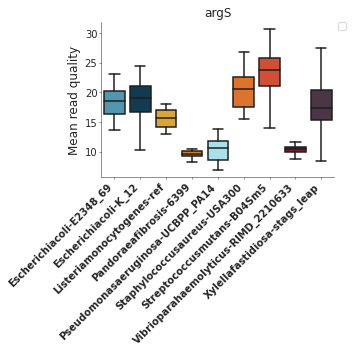

No handles with labels found to put in legend.


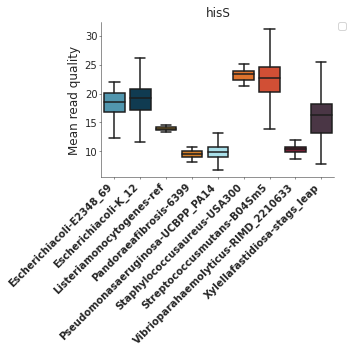

No handles with labels found to put in legend.


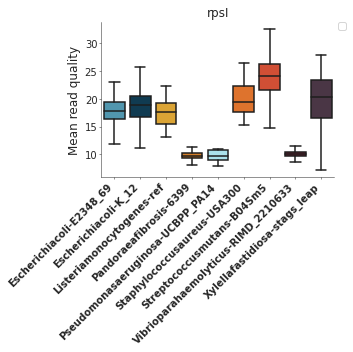

No handles with labels found to put in legend.


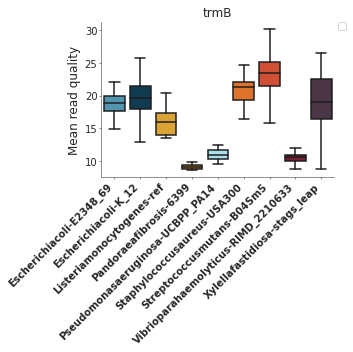

No handles with labels found to put in legend.


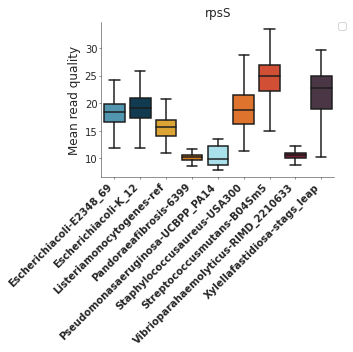

No handles with labels found to put in legend.


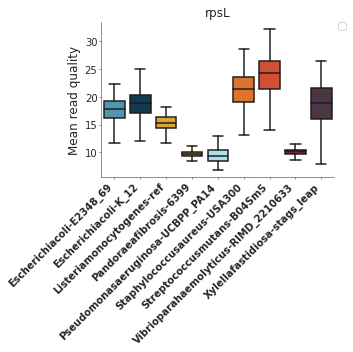

No handles with labels found to put in legend.


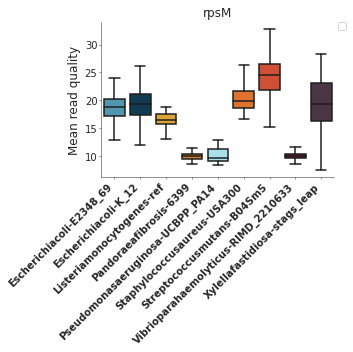

No handles with labels found to put in legend.


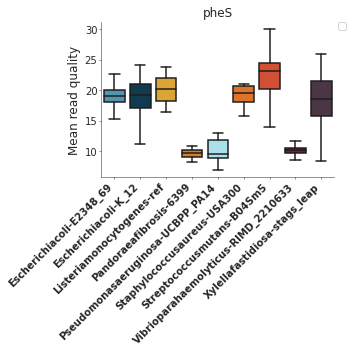

No handles with labels found to put in legend.


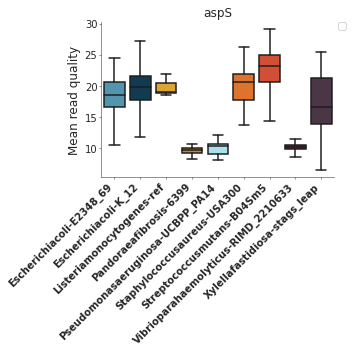

No handles with labels found to put in legend.


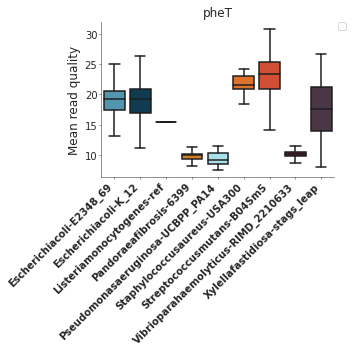

No handles with labels found to put in legend.


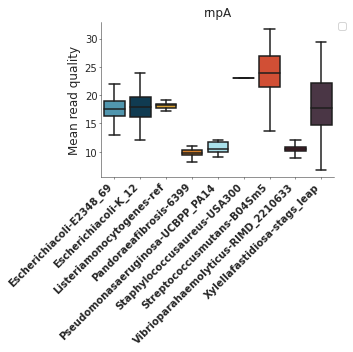

No handles with labels found to put in legend.


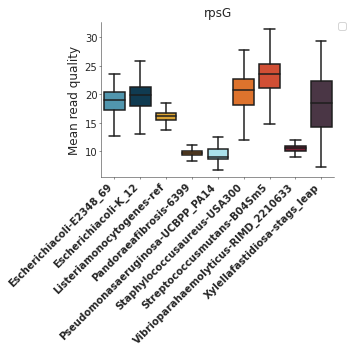

No handles with labels found to put in legend.


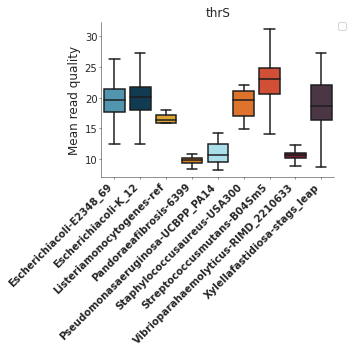

No handles with labels found to put in legend.


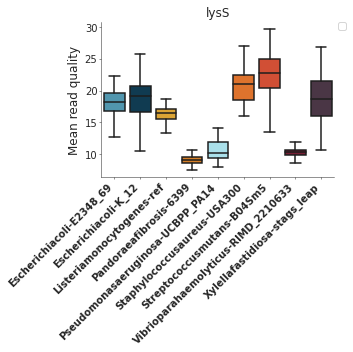

No handles with labels found to put in legend.


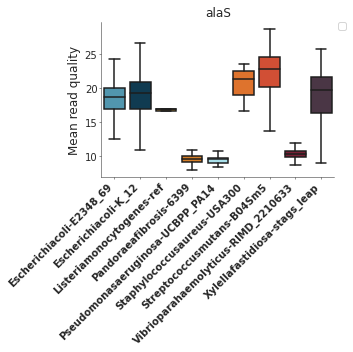

No handles with labels found to put in legend.


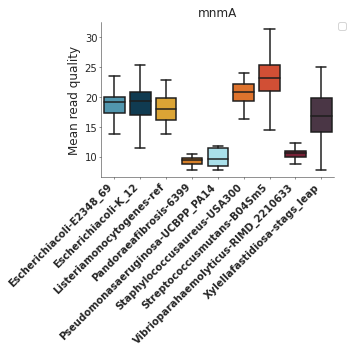

No handles with labels found to put in legend.


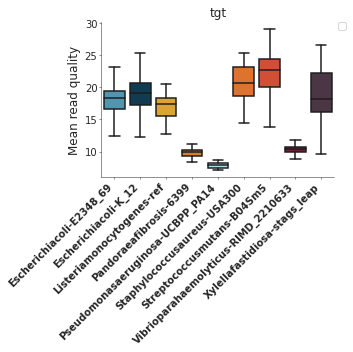

No handles with labels found to put in legend.


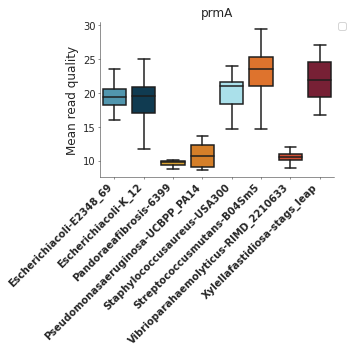

No handles with labels found to put in legend.


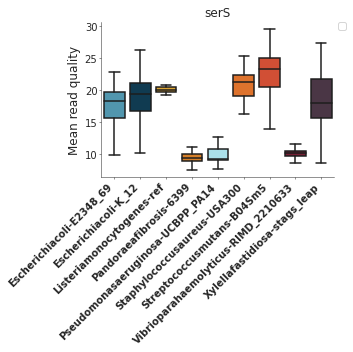

No handles with labels found to put in legend.


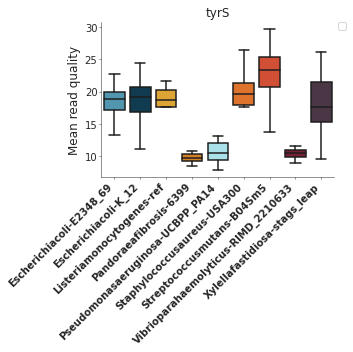

No handles with labels found to put in legend.


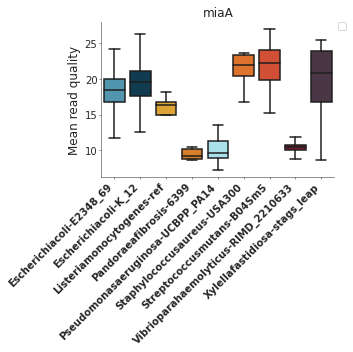

No handles with labels found to put in legend.


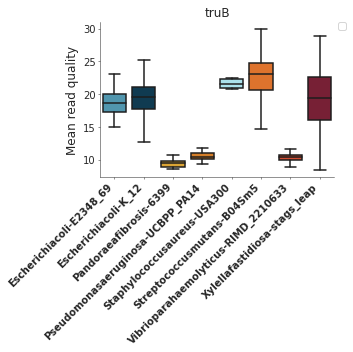

No handles with labels found to put in legend.


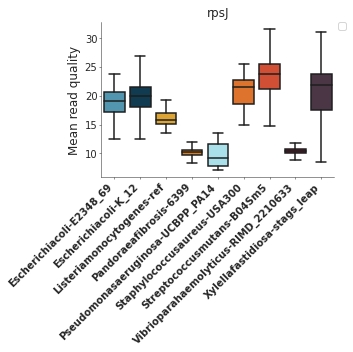

No handles with labels found to put in legend.


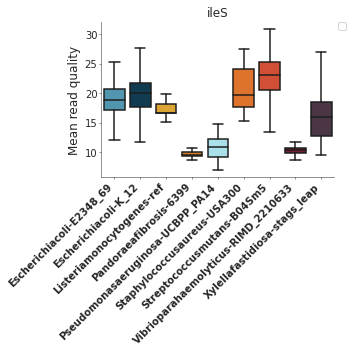

No handles with labels found to put in legend.


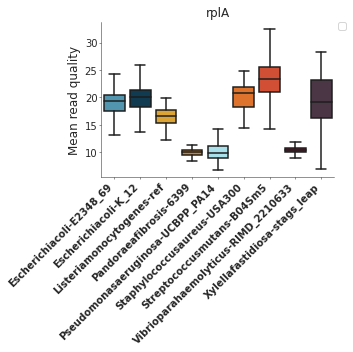

No handles with labels found to put in legend.


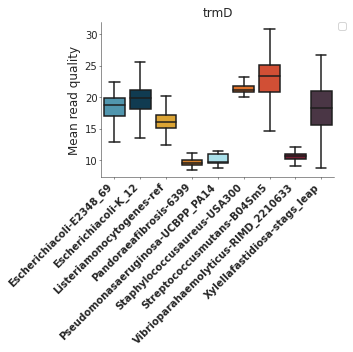

No handles with labels found to put in legend.


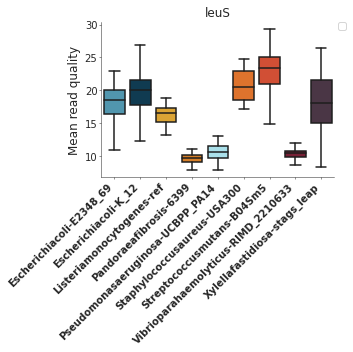

No handles with labels found to put in legend.


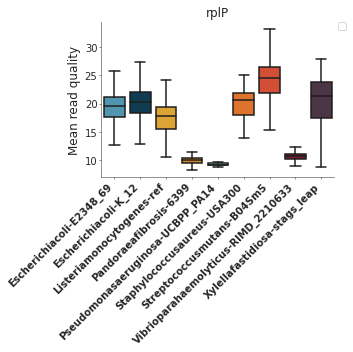

No handles with labels found to put in legend.


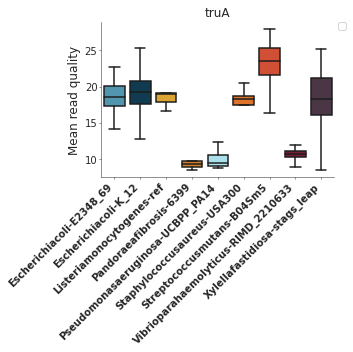

No handles with labels found to put in legend.


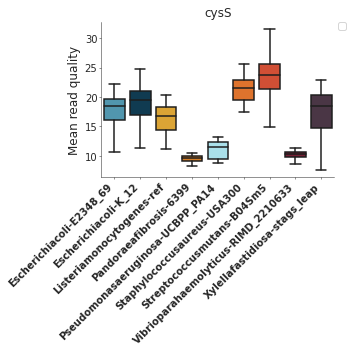

No handles with labels found to put in legend.


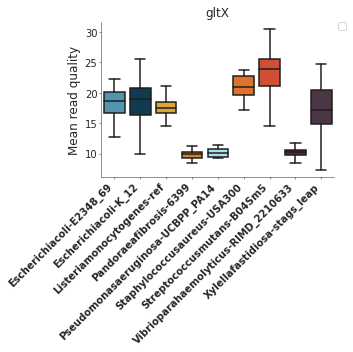

No handles with labels found to put in legend.


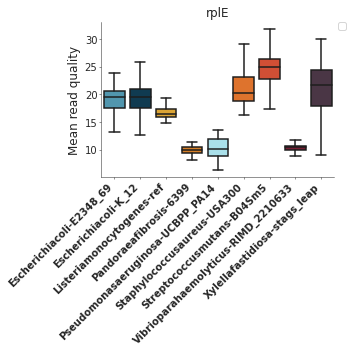

No handles with labels found to put in legend.


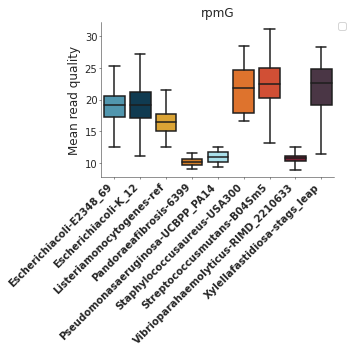

No handles with labels found to put in legend.


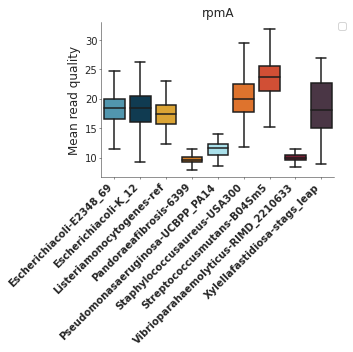

In [23]:
from sciviso import Boxplot
import matplotlib.pyplot as plt

opts = {'figsize': (5, 5), 'palette': ['#429EBD', '#053F5C', '#F7AD19', '#F27F0C', '#9FE7F5', '#FB6D10', '#EB3E1B', '#86112E', '#4D3347', '#2E2E41'], 
        'title_font_size': 12, 'axis_font_size': 10, 
        'label_font_size': 10, 's': 60, 'bins': 20, 'colour':'#053F5C', 
       'opacity': 0.7}

for gene in list(set(vis_df['Gene'].values)):
    gene_vis_df = vis_df[vis_df['Gene'] == gene]
    box = Boxplot(gene_vis_df, "Annotation", "Mean", add_dots=False, config=opts,
                  add_stats=False, title=gene, ylabel='Mean read quality')
    box.plot()
    plt.savefig(f'{fig_dir}{gene.replace(" ", "_")}.svg', transparent=True)
    plt.show()

No handles with labels found to put in legend.


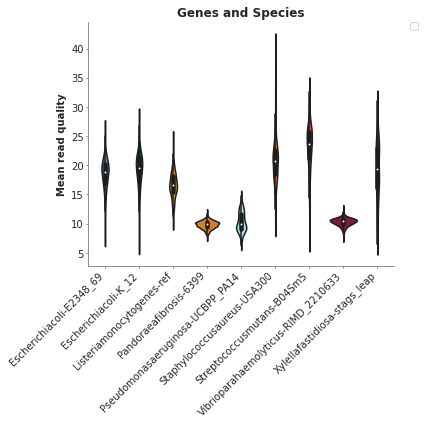

In [24]:
from sciviso import Violinplot
# It's prettu clear that the 
opts = {'figsize': (6, 6), 'palette': ['#429EBD', '#053F5C', '#F7AD19', '#F27F0C', '#9FE7F5', '#FB6D10', '#EB3E1B', '#86112E', '#4D3347', '#2E2E41'], 
        'title_font_size': 12, 'axis_font_size': 10, 
        'label_font_size': 10, 's': 60, 'bins': 20, 'colour':'#053F5C', 
       'opacity': 0.7}
title = f'Genes and Species'
box = Violinplot(vis_df, "Annotation", "Mean", add_dots=False, title=title,
                 add_stats=False, config=opts, ylabel='Mean read quality')
box.plot()
plt.savefig(f'{fig_dir}{title.replace(" ", "_")}.svg', transparent=True)

<AxesSubplot:>

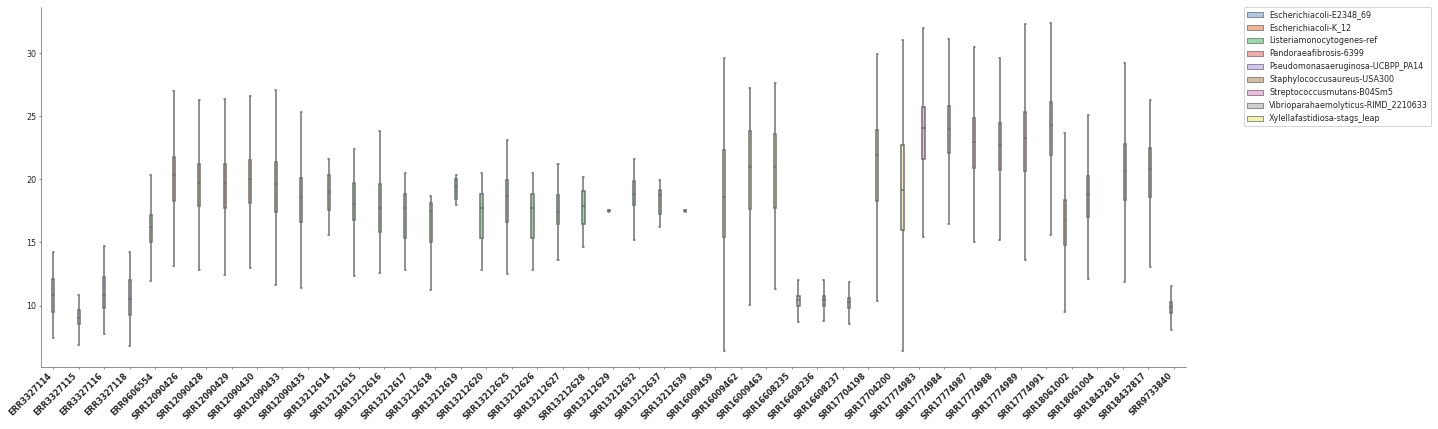

In [20]:
from sciviso import Violinplot
# It's prettu clear that the 
opts = {'figsize': (20, 6)}
box = Boxplot(vis_df, "Run", "Mean", add_dots=False, hue="Annotation", add_stats=False, 
              config=opts)
box.plot()

In [18]:
# Look at the gene's distribution of errors
one_gene = one_gene.dropna(axis=1)

In [20]:
one_gene[one_gene.columns[2:]]

,2,3,4,5,6,7,8,9,10,11,...,178,179,180,181,182,183,184,185,186,187
1,4,5,21,19,3,18,18,15,18,6,...,6.0,4.0,27.0,23.0,27.0,35.0,38.0,32.0,32.0,30.0
2,2,8,9,9,10,10,10,11,11,10,...,21.0,18.0,8.0,29.0,28.0,29.0,26.0,26.0,34.0,3.0
3,2,7,12,9,5,4,6,7,7,6,...,5.0,17.0,6.0,2.0,5.0,4.0,1.0,4.0,7.0,10.0
4,17,18,12,6,5,21,14,4,5,15,...,28.0,26.0,28.0,26.0,4.0,4.0,4.0,5.0,32.0,20.0
5,7,12,13,7,8,9,12,3,4,1,...,21.0,23.0,15.0,15.0,14.0,14.0,22.0,24.0,33.0,15.0
6,14,12,9,5,3,4,8,10,19,19,...,27.0,18.0,19.0,15.0,12.0,24.0,24.0,26.0,31.0,33.0
7,6,9,9,22,13,12,8,13,8,6,...,12.0,3.0,6.0,21.0,5.0,25.0,20.0,22.0,26.0,27.0
8,10,15,2,1,4,4,4,5,4,4,...,15.0,2.0,3.0,12.0,15.0,12.0,28.0,20.0,15.0,7.0
9,3,3,3,3,3,3,3,3,3,3,...,3.0,4.0,16.0,4.0,17.0,8.0,8.0,22.0,24.0,31.0
10,3,8,6,6,8,3,4,3,2,2,...,30.0,30.0,29.0,28.0,31.0,26.0,19.0,20.0,23.0,25.0


5.846153846153846
7.961538461538462
8.423076923076923
8.423076923076923
8.23076923076923
7.653846153846154
8.192307692307692
7.346153846153846
8.26923076923077
7.846153846153846
7.3076923076923075
8.076923076923077
7.153846153846154
9.538461538461538
9.0
7.846153846153846
8.73076923076923
9.26923076923077
7.6923076923076925
9.076923076923077
11.038461538461538
9.807692307692308
9.576923076923077
9.538461538461538
10.76923076923077
9.461538461538462
9.884615384615385
11.384615384615385
11.26923076923077
9.923076923076923
10.807692307692308
10.192307692307692
11.115384615384615
10.5
9.76923076923077
9.538461538461538
11.038461538461538
9.692307692307692
11.076923076923077
10.615384615384615
9.538461538461538
10.26923076923077
12.384615384615385
10.115384615384615
9.538461538461538
8.115384615384615
7.269230769230769
10.192307692307692
11.076923076923077
12.653846153846153
11.615384615384615
12.76923076923077
13.538461538461538
13.307692307692308
14.076923076923077
12.961538461538462
12.8

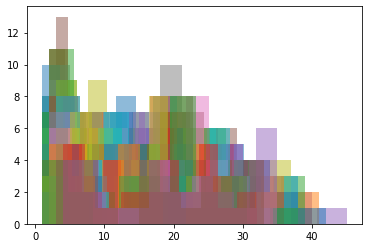

In [32]:
# For each column and then for each row look at the distribution of errors
import matplotlib.pyplot as plt 

for col in one_gene.columns[2:]:
    print(np.mean(one_gene[col].values))

    plt.hist(one_gene[col].values, alpha=0.5)

17.376344086021504
16.446236559139784
13.301075268817204
19.22043010752688
10.209677419354838
22.35483870967742
16.123655913978496
15.666666666666666
14.688172043010752
14.682795698924732
12.231182795698924
9.82258064516129
15.274193548387096
17.043010752688172
16.870967741935484
10.263440860215054
13.075268817204302
14.338709677419354
11.93010752688172
10.026881720430108
13.478494623655914
11.78494623655914
12.870967741935484
18.06451612903226
14.026881720430108
17.403225806451612


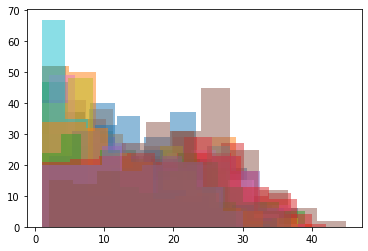

In [30]:
import numpy as np
for row in one_gene.values:
    print(np.mean(row[2:]))
    plt.hist(row[2:], alpha=0.5)